## 1. Problem Definition

Goal: Predicting price of bulldozers using a regression machine-learning algorithm

## 2. Data

The data that we will use will be pulled from a Kaggle competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data. 

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluaton

In order to be successful, the RMSLE (Root Mean Squared Log Error) between actual and predicted auction prices must be as low as possible.

## 4. Features

This project includes the features listed <a href="C:\Users\jtass\PycharmProjects\bulldozer-pricing\data\bluebook-for-bulldozers\Data Dictionary.xlsx">here</a>.

### Importing the tools

We will use a combination of Pandas, Numpy, Matplotlib, and scikit-learn.

In [3]:
# Data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Cleaning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# Evaluation
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

### Exploratory Data Analysis

In [2]:
# Import data sets
train_val_df = pd.read_csv("./data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)


In [3]:
# View the data (training)
train_val_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Investigate data types (training)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

Key pieces of information to investigate:
* Model ID
* Year Made
* Date Sold
* Sale Price

In [5]:
# Investigate missing data (training)
train_val_df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

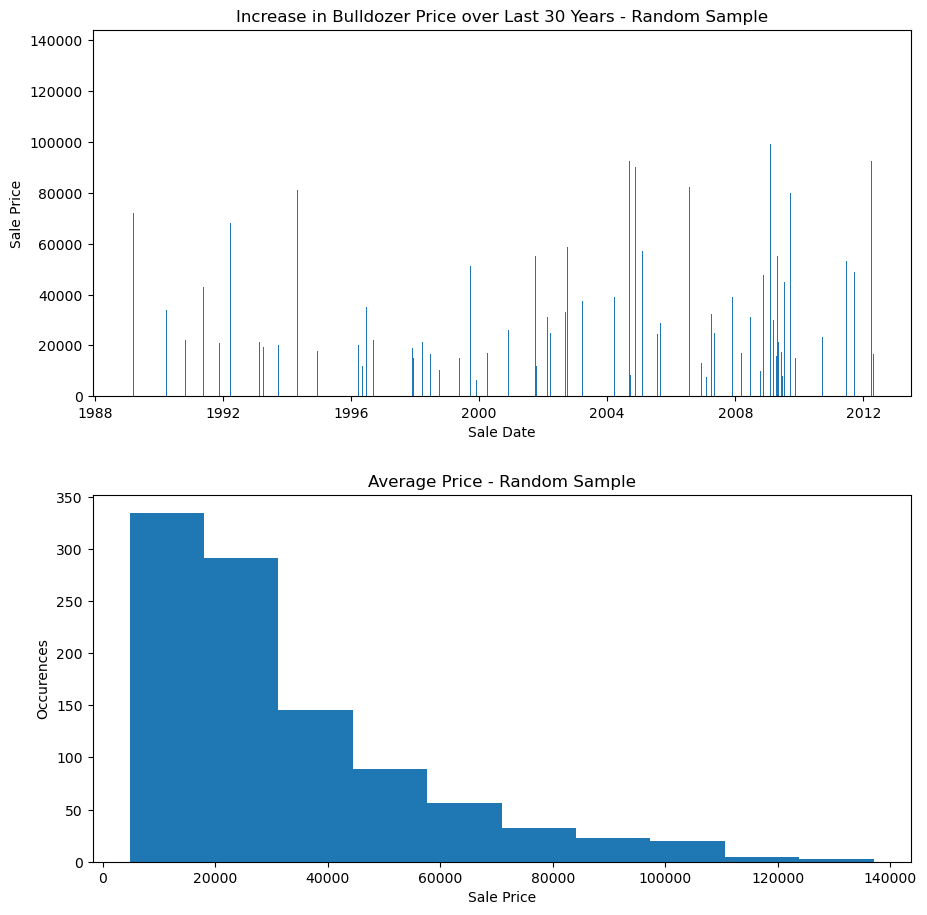

In [6]:
# Investigate Price vs Sale Date
train_val_df['saledate'] = pd.to_datetime(train_val_df["saledate"])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
fig.tight_layout(pad=5.0)

np.random.seed(42)
random_sample = train_val_df.sample(1000)
sample_sale_date = random_sample["saledate"]
sample_sale_price = random_sample["SalePrice"]

ax1.bar(sample_sale_date, sample_sale_price)
ax1.set(title="Increase in Bulldozer Price over Last 30 Years - Random Sample", xlabel="Sale Date", ylabel="Sale Price");

ax2.hist(sample_sale_price)
ax2.set(title="Average Price - Random Sample", xlabel="Sale Price", ylabel="Occurences");

Key findings:

* Price has increased slightly over time
* Price is typically below ~35000

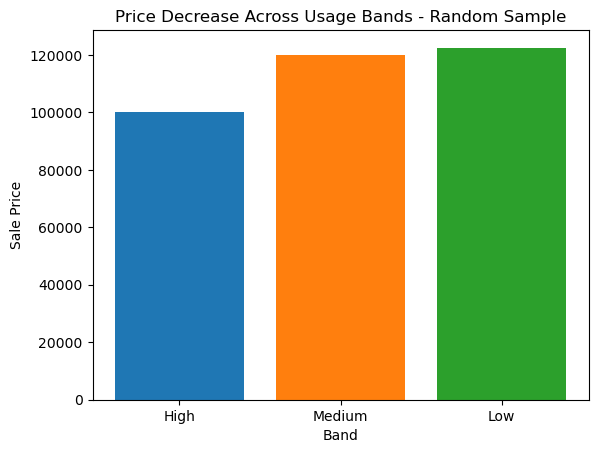

In [7]:
# Investigate Price to Usage Band

# Set random seed
np.random.seed(42)

# Clean usage band to be numeric for bar graph
random_sample = train_val_df.sample(1000)
nulls = pd.get_dummies(random_sample["UsageBand"])
merged_sample = pd.concat([nulls, random_sample], axis='columns')
merged_sample.drop(["UsageBand"], axis='columns')

# Set random subsets for band and price
sample_usage_band_high = merged_sample[merged_sample["High"] == 1]
sample_usage_band_med = merged_sample[merged_sample["Medium"] == 1]
sample_usage_band_low = merged_sample[merged_sample["Low"] == 1]

# Plot

fig, ax1 = plt.subplots()

# Define structure of graph
ax1.bar("High", sample_usage_band_high["SalePrice"], label="High")
ax1.bar("Medium", sample_usage_band_med["SalePrice"], label="Medium")
ax1.bar("Low", sample_usage_band_low["SalePrice"], label="Low")
ax1.set(title="Price Decrease Across Usage Bands - Random Sample", xlabel="Band", ylabel="Sale Price");

Findings:

* On average, low and medium usage have smaller price difference. High usage typically reduces price significantly.

### Sort DataFrame by saledate

Make a copy of the DataFrame sorted by datatime and save to a temp table as a backup.

In [8]:
# Sort ascending by date

train_val_df.sort_values(by=["saledate"], inplace=True, ascending=True)

# Create duplicate dataframe for backup

df_temp = train_val_df.copy()

### Add datetime parameters for `saledate` column

In [9]:
# Enrich dataframe with date time features

df_temp["saleYear"] = df_temp["saledate"].dt.year
df_temp["saleMonth"] = df_temp["saledate"].dt.month
df_temp["saleDay"] = df_temp["saledate"].dt.day
df_temp["saleDayOfWeek"] = df_temp["saledate"].dt.day_of_week
df_temp["saleDayOfYear"] = df_temp["saledate"].dt.day_of_year

# Remove sale date

df_temp.drop(["saledate"], axis=1, inplace=True)

## 5. Modeling

### Cleaning the Data

First, we will convert string data into numbers, which we can do with Pandas categories.

In [10]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [11]:
# Find columns that contain strings and convert to category

for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered

### Fill Missing Values

In [13]:
# Find columns with missing numeric data
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column to tell if it is missing or not
            df_temp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_temp[label] = content.fillna(content.median())


In [14]:
# Filling and converting categorical variables into numbers
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate if sample had missing value
        df_temp[label+"_is_missing"] = pd.isnull(content)
        # Turn NaNs into numbers and add + 1 (we add 1 because a -1 is added to missing values AKA NaN)
        df_temp[label] = pd.Categorical(content).codes + 1

### Save Preprocessed Data

In [90]:
# Export current tmp dataframe
df_temp.to_csv("data/bluebook-for-bulldozers/train_temp.csv")

### Create a Model

In [15]:
%%time

# Instantiate and fit model
model = RandomForestRegressor(n_jobs=-1, random_state=8)
model.fit(df_temp.drop(["SalePrice"], axis=1), df_temp["SalePrice"])

CPU times: total: 11min 56s
Wall time: 57 s


RandomForestRegressor(n_jobs=-1, random_state=8)

In [16]:
# For demonstration purposes, score data on the same training data

model.score(df_temp.drop(["SalePrice"], axis=1), df_temp["SalePrice"])

0.9827258142317294

### Evaluate Our Model

Reminder: The train and validation datasets include data up through a set time period, so we can split the data again based on date.

In [17]:
df_train = df_temp[df_temp["saleYear"] < 2012]
df_valid = df_temp[df_temp["saleYear"] >= 2012]

X_train, y_train = df_train.drop(["SalePrice"], axis=1), df_train["SalePrice"]
X_valid, y_valid = df_valid.drop(["SalePrice"], axis=1), df_valid["SalePrice"]

In [18]:
# Refit using new train split
model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=8)

In [19]:
# Re-evaluate using validation split
model.score(X_valid, y_valid)


0.8003850254880713

In [31]:
# Build an evaluation function for RMLSE

def rmsle(y_true, y_pred):
    """
    Calculatese Root Mean Squared Log Error of the true label and predicted label
    """
    return mean_squared_log_error(y_true, y_pred)**0.5

def rmse(y_true, y_pred):
    """
    Calculatese Root Mean Squared Log Error of the true label and predicted label
    """
    return mean_squared_error(y_true, y_pred)**0.5

def show_scores(model, X_train, X_valid):
    """
    Shows scores given a model.
    """
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        "Training RMSE": rmse(y_train, train_preds),
        "Valid RMSE": rmse(y_valid, val_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "Valid RMSLE": rmsle(y_valid, val_preds),
        "Training R2": r2_score(y_train, train_preds),
        "Valid R2": r2_score(y_valid, val_preds)
    }

    return scores

In [21]:
# Reinstntiate and model with max samples (for quicker testing). Evalue using show_scores function.
model = RandomForestRegressor(n_jobs=-1, random_state=8, max_samples=50000)
model.fit(X_train, y_train)

show_scores(model, X_train, X_valid)

{'Training RMSE': 8377.46097817337,
 'Valid RMSE': 13211.796963047234,
 'Training RMSLE': 0.26437858509884693,
 'Valid RMSLE': 0.3986410288581207,
 'Training R2': 0.8677554168097424,
 'Valid R2': 0.7458748154047583}

We can see that the RMSE is skewed significantly compared to the RMSLE due to outliers (Note: They are still proportional to one another). RMSLE is a relative error and penalizes underestimating more than overestimating. Values closer to 0 are best for both.

For R2 scores, values closer to 1 indicate a high level or correlation between features and label.

### Hyperparamter tuning with RandomizedSearchCV

In [22]:
# Create a RSCV model
param_grid = {
    "min_samples_split": np.arange(2, 4, 1),
    "min_samples_leaf": np.arange(1, 4, 1),
    "max_features": ["sqrt", "log2"],
    "max_samples": np.arange(10000, 400000, 50000),
    "random_state": [8]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(random_state=8, n_jobs=-1), param_grid)
rs_model.fit(X_train, y_train)

c:\Users\jtass\PycharmProjects\bulldozer-pricing\env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jtass\PycharmProjects\bulldozer-pricing\env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jtass\PycharmProjects\bulldozer-pricing\env\lib\site-packages\sklearn\ensemble\_forest.py", line 389, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  File "c:\Users\jtass\PycharmProjects\bulldozer-pricing\env\lib\site-packag

RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=8),
                   param_distributions={'max_features': ['sqrt', 'log2'],
                                        'max_samples': array([ 10000,  60000, 110000, 160000, 210000, 260000, 310000, 360000]),
                                        'min_samples_leaf': array([1, 2, 3]),
                                        'min_samples_split': array([2, 3]),
                                        'random_state': [8]})

In [23]:
# Check best params
rs_model.best_params_

{'random_state': 8,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 310000,
 'max_features': 'sqrt'}

In [26]:
# Evaluate the RSCV model
show_scores(rs_model, X_train, X_valid)

{'Training RMSE': 5913.318478054432,
 'Valid RMSE': 20378.58950463913,
 'Training RMSLE': 0.20575032300516757,
 'Valid RMSLE': 0.5799691008734648,
 'Training R2': 0.9341105921623424,
 'Valid R2': 0.39539439675554855}

### Train model with the best hyperparameters

*NOTE:* These were found with 100 iterations of `RandomizedSearchCV` by a colleague.

In [13]:
%%time

# Most ideal hyperparamaters
ideal_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, min_samples_split=14, max_features=0.5, n_jobs=-1, random_state=8)

# Fit the model

ideal_model.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [30]:
show_scores(ideal_model, X_train, X_valid)

{'Training RMSE': 6024.936933516718,
 'Valid RMSE': 12983.608624972669,
 'Training RMSLE': 0.19348088517636455,
 'Valid RMSLE': 0.39357756445120423,
 'Training R2': 0.9315996891386509,
 'Valid R2': 0.7545772846621788}

In [34]:
test_df = pd.read_csv("./data/bluebook-for-bulldozers/Test.csv")

In [17]:
# Create date function to be used with the pipeline
def transform_date(df):
    df["saledate"] = pd.to_datetime(df["saledate"])
    df["saleYear"] = df["saledate"].dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["saleDayOfWeek"] = df["saledate"].dt.day_of_week
    df["saleDayOfYear"] = df["saledate"].dt.day_of_year
    df.drop(["saledate"], axis=1, inplace=True)
    return df

In [18]:
date_pipeline = Pipeline(steps=[
    ("date_transform", FunctionTransformer(transform_date, accept_sparse=True))
])

In [19]:
# Identify categorical data and convert to numbers
cat_features = []

for label, content in test_df.items():
    if pd.api.types.is_string_dtype(content):
        test_df[label] = content.astype("category").cat.as_ordered
        cat_features.append(label)

cat_features.remove('saledate')
cat_features


['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [20]:
# Set up categorical pipeline

cat_imputer = SimpleImputer(strategy="most_frequent")
one_hot = OneHotEncoder(handle_unknown='ignore', sparse=True)

cat_pipeline = Pipeline(steps=[
    ('impute', cat_imputer),
    ('one-hot', one_hot),
])

In [21]:
# Identify numeric data

num_features = [labels for labels, content in test_df.items() if pd.api.types.is_numeric_dtype(content)]

In [22]:
# Create numeric pipeline
num_imputer = SimpleImputer(strategy="median")

num_pipeline = Pipeline(steps=[
    ('impute', num_imputer)
])

In [23]:
# Merge previous pipelines into the column transformer (excluding date because that is itself a transformer)
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_features),
    ('cat_pipeline', cat_pipeline, cat_features)
], remainder="drop", n_jobs=-1)

In [24]:
ideal_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, min_samples_split=14, max_features=0.5, n_jobs=-1, random_state=8)

# Create model pipeline by adding transformers and model
model_pipeline = Pipeline(steps=[
    ('date_pipeline', date_pipeline),
    ("col_trans", col_trans),
    ("model", ideal_model)
])

display(model_pipeline)

Pipeline(steps=[('date_pipeline',
                 Pipeline(steps=[('date_transform',
                                  FunctionTransformer(accept_sparse=True,
                                                      func=<function transform_date at 0x00000219A1A9EF80>))])),
                ('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SalesID', 'MachineID',
                                                   'ModelID', 'datasource',
                                                   'auctionee...
                                                   'Drive_System', 'Enclosure',
                                                   'Forks', 'Pad_Type',
                                                   'Ride_Control', 'Stick',
                                                   'Transmission',
                                                   'Turbocharged',
                                                   'Blade_Extension',
                                                   'Blade_Width',
                                                   'Enclosure_Type',
                                                   'Engine_Horsepower',
                                                   'Hydraulics', 'Pushblock',
                                                   'Ripper', 'Scarifier',
                                                   'Tip_Control', 'Tire_Size',
                                                   'Coupler', ...])])),
                ('model',
                 RandomForestRegressor(max_features=0.5, min_samples_split=14,
                                       n_estimators=40, n_jobs=-1,
                                       random_state=8))])

In [25]:
from sklearn.inspection import permutation_importance

# Reimport Data
df_train = pd.read_csv("./data/bluebook-for-bulldozers/Train.csv", low_memory=False)

# Split data
X_train, y_train = df_train.drop(["SalePrice"], axis=1), df_train["SalePrice"]

# Fit model pipeline
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('date_pipeline',
                 Pipeline(steps=[('date_transform',
                                  FunctionTransformer(accept_sparse=True,
                                                      func=<function transform_date at 0x00000219A1A9EF80>))])),
                ('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['SalesID', 'MachineID',
                                                   'ModelID', 'datasource',
                                                   'auctionee...
                                                   'Drive_System', 'Enclosure',
                                                   'Forks', 'Pad_Type',
                                                   'Ride_Control', 'Stick',
                                                   'Transmission',
                                                   'Turbocharged',
                                                   'Blade_Extension',
                                                   'Blade_Width',
                                                   'Enclosure_Type',
                                                   'Engine_Horsepower',
                                                   'Hydraulics', 'Pushblock',
                                                   'Ripper', 'Scarifier',
                                                   'Tip_Control', 'Tire_Size',
                                                   'Coupler', ...])])),
                ('model',
                 RandomForestRegressor(max_features=0.5, min_samples_split=14,
                                       n_estimators=40, n_jobs=-1,
                                       random_state=8))])

In [32]:
# Validate model (NOTE: Data will be overfit since validation subset taken from training model)

# Reimport Data
df_train = pd.read_csv("./data/bluebook-for-bulldozers/Train.csv", low_memory=False)

# Split data
X_train, y_train = df_train[:350000].drop(["SalePrice"], axis=1), df_train["SalePrice"][:350000]
X_valid, y_valid = df_train[350000:].drop(["SalePrice"], axis=1), df_train["SalePrice"][350000:]

show_scores(model_pipeline, X_train, X_valid)

{'Training RMSE': 6296.801782427923,
 'Valid RMSE': 5188.760517468937,
 'Training RMSLE': 0.18366256814022797,
 'Valid RMSLE': 0.15105562559647034,
 'Training R2': 0.9239982804052238,
 'Valid R2': 0.9545246712749941}

In [35]:
# Complete predictions with X_test
test_df = pd.read_csv("./data/bluebook-for-bulldozers/Test.csv")
test_preds = model_pipeline.predict(test_df)

In [36]:
# Output new file
test_preds_df = pd.DataFrame(data=test_preds)
test_preds_df.to_csv("data/test_predictions.csv")

### Calculate Feature Importance

Because there is high variability within feature values, we will use feature permutation rather than mean decrease in impurity.

In [64]:
# Get feature names from one hot encoder
cat_features = pd.Series(col_trans.named_transformers_["cat_pipeline"].named_steps['one-hot'].get_feature_names_out())
num_features = pd.Series(col_trans.named_transformers_["num_pipeline"].get_feature_names_out())

attribute = cat_features.append(num_features)

C:\Users\jtass\AppData\Local\Temp\ipykernel_6952\3512136371.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attribute = cat_features.append(num_features)


In [65]:
len(ideal_model.feature_importances_), len(attribute)


(7721, 7721)

In [66]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({
            "features": columns,
            "feature_importances": importances
        }).sort_values("feature_importances", ascending=False).reset_index(drop=True))

    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

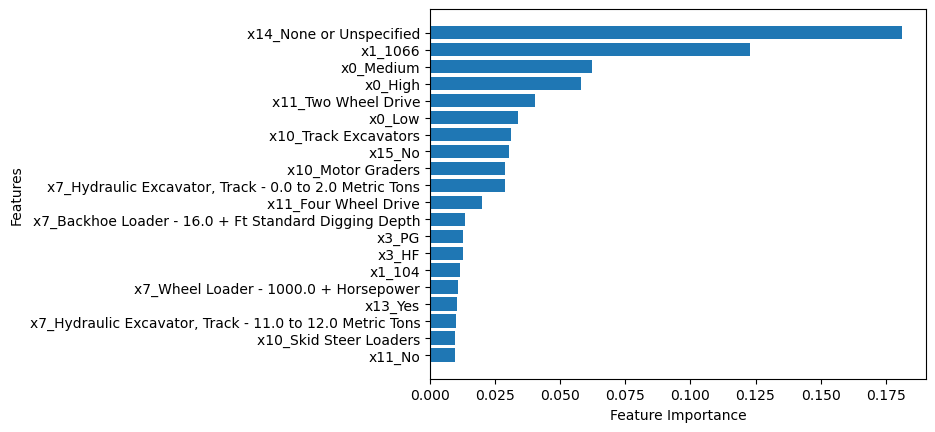

In [68]:
plot_features(attribute, ideal_model.feature_importances_)